#Motivation

Modeling comprehensive concepts in language is very interesting for me. Therefore, I chose this dataset:)

# Challenges

The challenge of the competition is to classify comments with an unintended bias, find out which are toxic.

#Task

The task is to find a pattern for toxicity Recognition from given text data and classify it into toxic or non-toxic.

In [6]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import gc
import os
import warnings
from plotnine import *
from wordcloud import WordCloud, STOPWORDS
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from gensim import corpora, models
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
np.random.seed(2018)
warnings.filterwarnings('ignore')

In [7]:
#Aquire Data

!unzip /content/test.csv.zip
!unzip /content/test_labels.csv.zip
!unzip /content/train.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  /content/train.csv.zip
  inflating: train.csv               


In [8]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
targets=pd.read_csv('test_labels.csv')

In [9]:
targets

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [10]:
test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [11]:
#concat targets and test data

frames=[test, targets]
test_data=pd.concat(frames)

test_data.to_csv('test_data.csv')

In test data, we have two columns:


1.   Comment_text: comment (text data) string type, only train data for model.
2.   Id: unique id associated with a comment

In [12]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0



Train data has Columns: 

1. Comment_text: comment (text data) string type, only train data for model

2. Target: the toxicity of the associated comment, ranges between 0.0 to 1.0, our main aim is to predict this column.

3. Id: unique id associated with a comment.

4. Some subtypes are also given with train data: sever_toxicity, obscene, threat, insult, identity_hate.


let's see what is the dimension of our data

In [13]:
print("Train and test shape: {} {}".format(train.shape, test.shape))

Train and test shape: (159571, 8) (153164, 2)


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


# Data Exploration

Comments are stored in train and test in comment_text column.


**Toxicity subtype attributes:**

. severe_toxicity
. obscene
. threat
. insult
. identity_hate

# Target Feature

let's plot the histogram of our targets.

Text(0.5, 1.0, 'Histogram Plot of target')

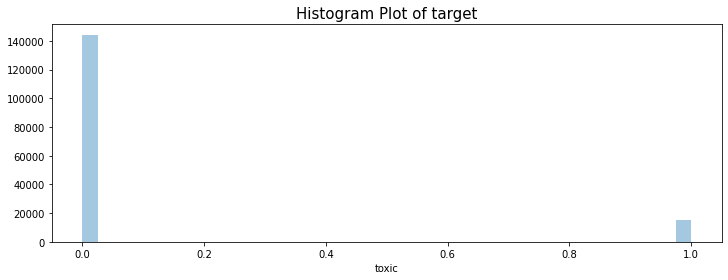

In [16]:
fig, axarr = plt.subplots(nrows=1,ncols=1,figsize=(12,4))
sns.distplot(train.toxic, kde=False, bins=40).set_title("Histogram Plot of target", fontsize=15)

Text(0.5, 1.0, 'Kernel Density Estimate(kde) Plot of target')

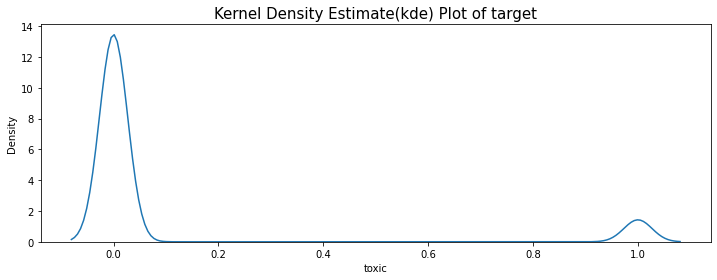

In [17]:
fig, axarr = plt.subplots(nrows=1,ncols=1,figsize=(12,4))
sns.kdeplot(train.toxic).set_title("Kernel Density Estimate(kde) Plot of target", fontsize=15)

The above plots tell us that most of the comments in the train data set are non-toxic. Also, kde is plotted to get the real shape of the data, not a line plot; because otherwise, we wouldn't get a smooth plot since a lot of outliers and inbetweeners would be introduced.

let's plot the distribution of toxicity subtypes in the train data to see the patterns.

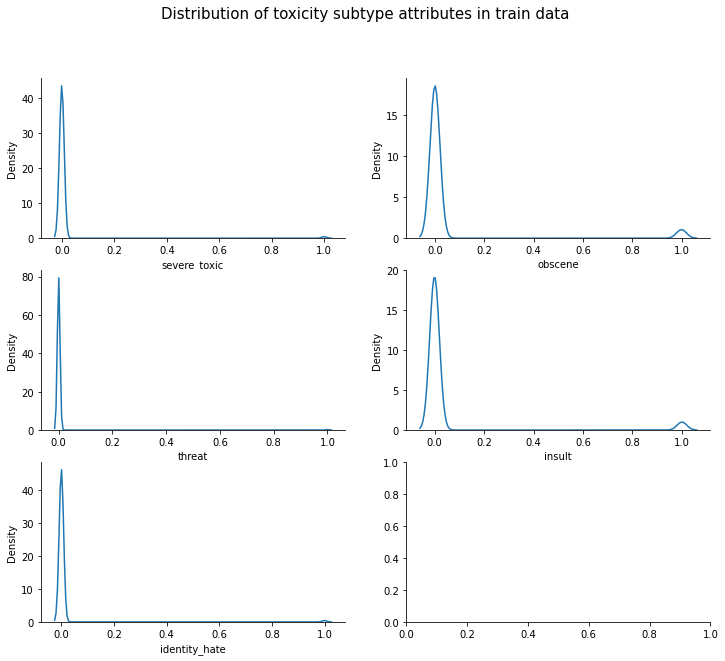

In [18]:
fig, axarr = plt.subplots(nrows=3,ncols=2,figsize=(12,10))
fig.suptitle('Distribution of toxicity subtype attributes in train data', fontsize=15)
sns.kdeplot(train['severe_toxic'], ax=axarr[0][0])
sns.kdeplot(train['obscene'], ax=axarr[0][1])
sns.kdeplot(train['threat'], ax=axarr[1][0])
sns.kdeplot(train['insult'], ax=axarr[1][1])
sns.kdeplot(train['identity_hate'], ax=axarr[2][0])
sns.despine()

So, the data distribution shapes of the target feature and its sub-types are similar.


Evaluation will be done like so:


*   target >= 0.5 ==> toxic comment
*   target < 0.5 ==> non-toxic comment





Let us plot a bar chart of the count of comments labelled as toxic vs non-toxic

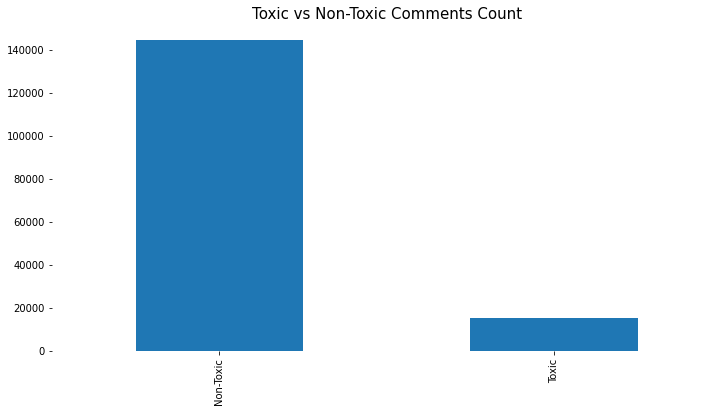

In [20]:
train['target_binarized'] = train['toxic'].apply(lambda x : 'Toxic' if  x >= 0.5 else 'Non-Toxic')
fig, axarr = plt.subplots(1,1,figsize=(12, 6))
train['target_binarized'].value_counts().plot.bar(fontsize=10).set_title("Toxic vs Non-Toxic Comments Count", 
                                                                         fontsize=15)
sns.despine(bottom=True,  left=True)

let's plot the correlation matrix as well.

In [24]:
f = (
    train.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
        .applymap(lambda v: float(v))
        .dropna()
)

In [25]:
f.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
f_corr=f.corr()

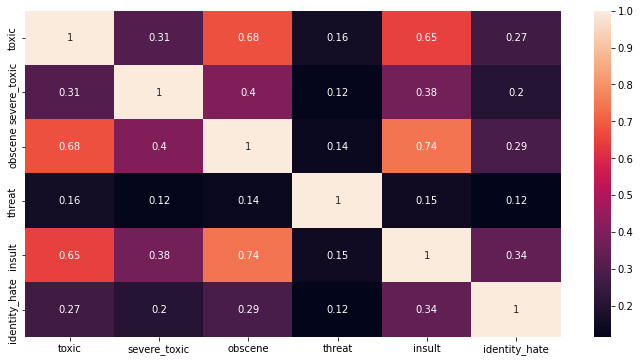

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.heatmap(f_corr, annot=True)

One thing that really stands out is the high degree of correlation between 'toxic' and its sub-types 'insult' & 'obsene'.

Insult & obsene have a high correlation.


# Comment Length Analysis

let's plot a distribution of comment length.

Text(0.5, 1.0, 'Distribution of comment_text_length')

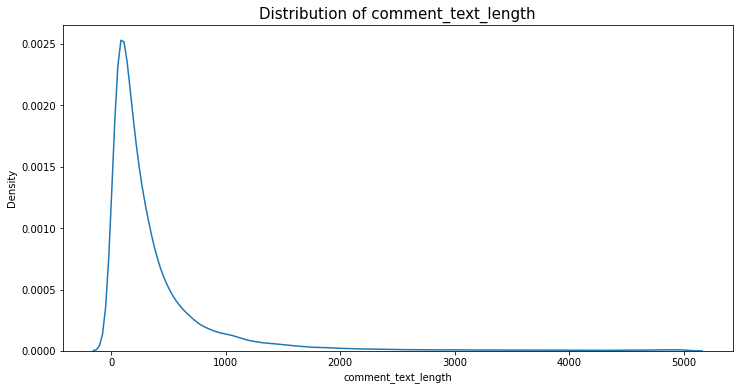

In [28]:
train['comment_text_length'] = train['comment_text'].apply(lambda x : len(x))
fig, axarr = plt.subplots(1,1,figsize=(12, 6))
sns.kdeplot(train['comment_text_length']).set_title("Distribution of comment_text_length", fontsize=15)

So, the maximum number of comments have a length of about ~50 characters

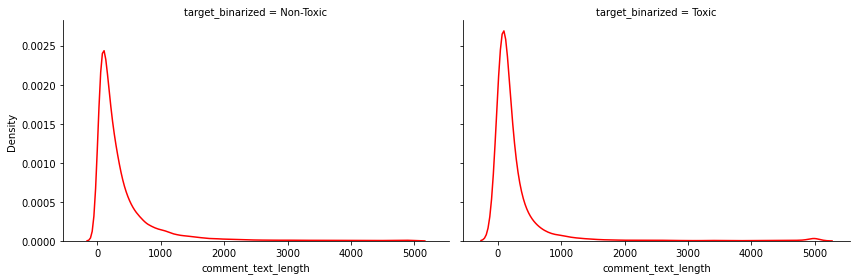

In [29]:
g = sns.FacetGrid(train, col="target_binarized", size=4, aspect=1.5)
g.map(sns.kdeplot, "comment_text_length", color='red')

Very long Toxic comments are lesser in number in comparison with Non-Toxic comments. 

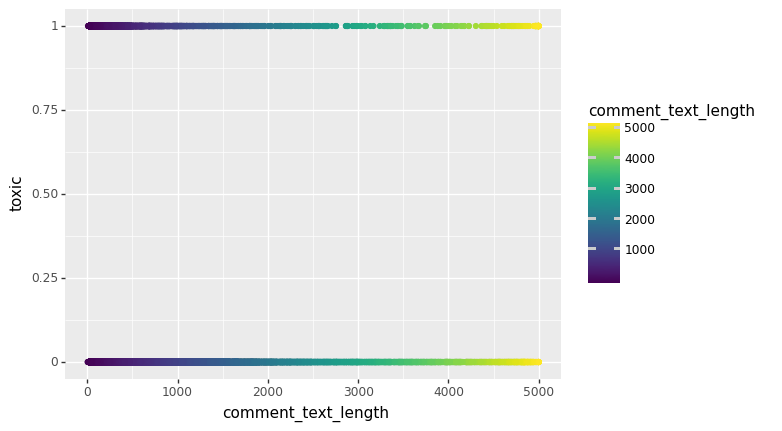

<ggplot: (8747969487293)>

In [32]:
(
    ggplot(train.sample(100000))
        + geom_point()
        + aes(color='comment_text_length')
        + aes('comment_text_length', 'toxic')
)

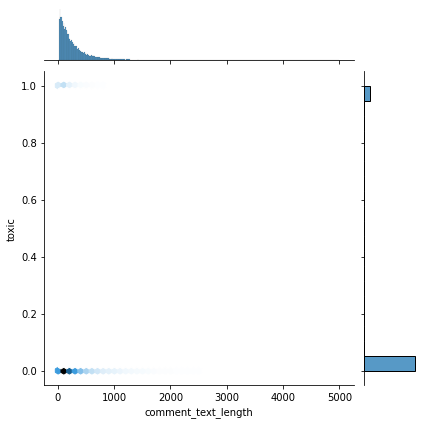

In [33]:
sns.jointplot(x='comment_text_length', y='toxic', data=train, kind='hex')

Highest overlap between comment_text_length = ~50 and target = 0

# Word Cloud

In [34]:
stopwords = set(STOPWORDS)

def plot_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

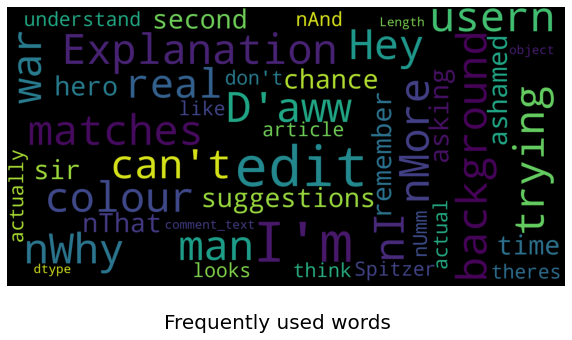

In [35]:
plot_wordcloud(train['comment_text'], title = 'Frequently used words')

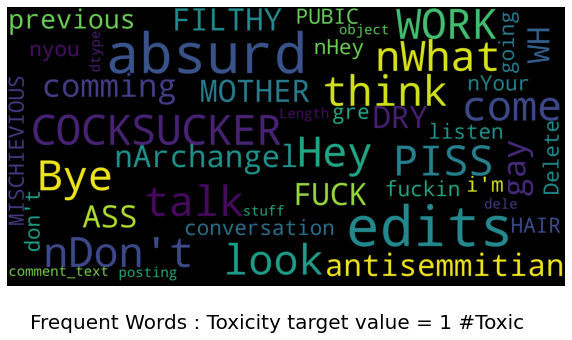

In [36]:
plot_wordcloud(train[train['toxic'] == np.max(train.toxic)]['comment_text'], title = 'Frequent Words : Toxicity target value = 1 #Toxic')

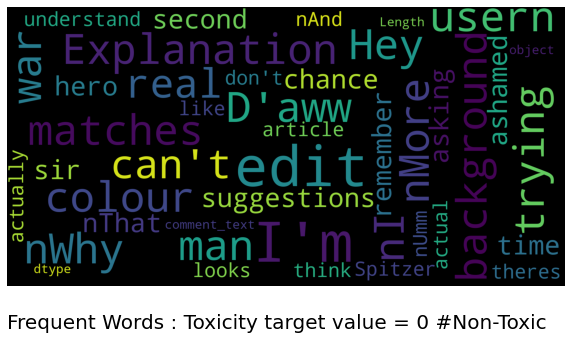

In [37]:
plot_wordcloud(train[train['toxic'] == np.min(train.toxic)]['comment_text'], title = 'Frequent Words : Toxicity target value = 0 #Non-Toxic')

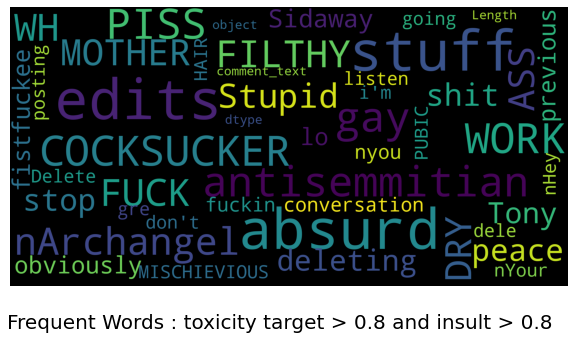

In [38]:
plot_wordcloud(train[(train['insult'] >0.8)&(train['toxic']>0.8)]['comment_text'], title = 'Frequent Words : toxicity target > 0.8 and insult > 0.8')

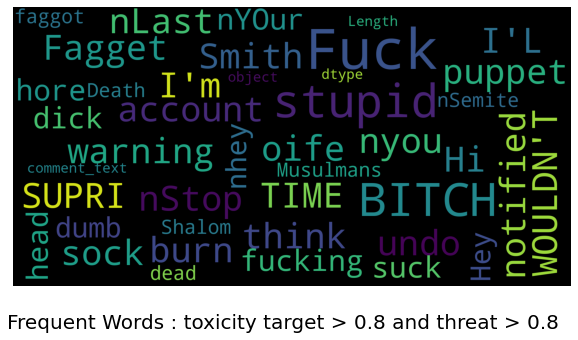

In [39]:
plot_wordcloud(train[(train['threat'] >0.8)&(train['toxic']>0.8)]['comment_text'], title = 'Frequent Words : toxicity target > 0.8 and threat > 0.8')